In [1]:
import numpyro, numpyro.distributions as dist
import jax, jax.random as random, jax.numpy as jnp, matplotlib.pyplot as plt

In [2]:
def inclination_dist(key, shape):
    icdf = lambda u: jnp.arccos(1 - u)
    u = random.uniform(key, shape)
    return icdf(u)

def mean_anomaly_dist(key,shape):
    return 2*jnp.pi*random.uniform(key,shape)

In [168]:
key = random.PRNGKey(11)
shape = (100000,)
i_samples = inclination_dist(key, shape)
M_samples = mean_anomaly_dist(key, shape)
e_samples = random.uniform(key,shape)

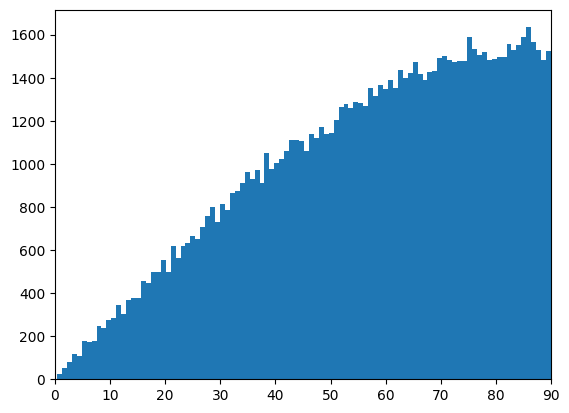

In [169]:
i_samples = i_samples*180/jnp.pi
plt.hist(i_samples, bins=100)
plt.xlim(0,90)
plt.show()

In [21]:
import jaxopt
from functools import partial

In [147]:
def kepler_equation(E, M, e):
    return E - e * jnp.sin(E) - M
def kepler_equation_fixed(E, M, e):
    return M + e * jnp.sin(E)

In [148]:
F = partial(kepler_equation, M=M_samples,e=e_samples)
F_fixed = partial(kepler_equation_fixed, M=M_samples,e=e_samples)

In [149]:
%%time
E = []
for i in range(len(M_samples)):
    E.append(jaxopt.Bisection(partial(kepler_equation, M=M_samples[i],e=e_samples[i]),
                lower=0, upper=2*jnp.pi).run().params)

CPU times: user 26.9 s, sys: 2.66 s, total: 29.6 s
Wall time: 19.6 s


In [150]:
%%time
res = jaxopt.ScipyRootFinding(method='hybr',optimality_fun=F,
                             ).run(init_params=jnp.ones(shape=M_samples.shape)*jnp.pi).params

CPU times: user 393 ms, sys: 27.5 ms, total: 420 ms
Wall time: 395 ms


In [151]:
%%time
res_aa = jaxopt.FixedPointIteration(fixed_point_fun=F_fixed
                                    ).run(init_params=jnp.ones(shape=M_samples.shape)*jnp.pi).params

CPU times: user 55.7 ms, sys: 5.26 ms, total: 60.9 ms
Wall time: 36.9 ms


In [152]:
jnp.abs(kepler_equation(res, M_samples, e_samples)).max()

Array(4.7683716e-07, dtype=float32)

In [153]:
jnp.abs(kepler_equation(jnp.array(E), M_samples, e_samples)).max()

Array(9.953976e-06, dtype=float32)

In [154]:
jnp.abs(kepler_equation(res_aa, M_samples, e_samples)).max()

Array(5.722046e-06, dtype=float32)